# Multiclass Galaxy Image Classification in AWS Sagemaker

In this notebook, we try to classify the spiral galaxy images according to their incliantions. 

Inclinations that are used here for training the model have been originally obtained manually using the [Inclination Zoo online servie](http://edd.ifa.hawaii.edu/inclination/)

Here, we adopt a similar methodology to what presented [here](https://sagemaker-examples.readthedocs.io/en/latest/introduction_to_amazon_algorithms/imageclassification_caltech/Image-classification-fulltraining.html#PerformInference).

## Permissions and environment variables

The model has been constructed using the `AWS Sagemaker` service. 

- Training and Validation data are available to this notebook through the AWS S3 service in a bucket named `incnet64x64`. 
- Number of Training Images: `45172`
- Number of Validation Images: `12260`
- Number of Test Images: `3036`
- Image resolutions: `64x64` pixel^2

## Data Structure

- `s3://incnet64x64`
   - `full-train/`
     - train
        - `AWS_64x64_train.rec`
     - validation
        - `AWS_64x64_val.rec`
     - test
        - `<inc>_pgc<id>_<i>.jpg`   where `<inc>` is the galaxy label (discussed below), `<id>` is the galaxy ID number and `<i>` represents the orientation of the image with 0 being the original image and 1, 2, and 3 are its fillped versions.
        
Th training and validation data are presented in RecordIO Format: `.rec`. To acquire the required packages to handle split the data and handle the class labels, please refer to [MXNet’s recordio tool](https://mxnet.apache.org/versions/1.8.0/api/faq/recordio).
- `python im2rec.py --list --recursive  AWS_64x64_train AWS_64x64_train/`
- `python im2rec.py  AWS_64x64_train.lst AWS_64x64_train/`
 


## Labels

Labels are inclinations of spirals galaxies in our sample and measure the spatial orientation of a galaxy relative to the line of sight of an observer. Face-on spirals are assigned to have inclination of zero and the edge-on spirals have 90 degrees of incliantion. 

Because of the nature of our research, galaxies are selected to deviated more than 45 degrees from face-on. However during the manual process of measuring the inclinations on the [Galaxy Inlclination Zoo](http://edd.ifa.hawaii.edu/inclination/), some galaxies have been rejected due to the poor data quality or bein too face-on. The initial sample selesction has been carried out using the axis ratio of the galaxy image which is not an accurate proxy for the spirals inclinations.

- In this project, if a galaxy is labeled as face-on, we denote it with letter **F**.

- If a galaxy has been rejected by users, we denote it with letter **J**. All other galaxies are labelled with their measured inclinations. 

In [1]:
%%time

import boto3
import re
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri

role = get_execution_role()


bucket = "incnet64x64"

training_image = get_image_uri(boto3.Session().region_name, "image-classification")

s3_train_key = "full-train/train"
s3_validation_key = "full-train/validation"
s3_train = "s3://{}/{}/".format(bucket, s3_train_key)
s3_validation = "s3://{}/{}/".format(bucket, s3_validation_key)

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


CPU times: user 759 ms, sys: 103 ms, total: 863 ms
Wall time: 768 ms


## Training parameters


- **num_layers:** The number of layers (depth) for the network. We use `18` in this notebook.

- **num_training_samples:** This is the total number of training samples. It is set to `45172` for caltech dataset with the current split

- **epochs:** Number of training epochs

- **learning_rate:** Learning rate for training

- **mini_batch_size:** The number of training samples used for each mini batch.


In [2]:
# The algorithm supports multiple network depth (number of layers). They are 18, 34, 50, 101, 152 and 200
# For this training, we will use 18 layers
num_layers = "18"
# we need to specify the input image shape for the training data
image_shape = "3,64,64"
# we also need to specify the number of training samples in the training set
num_training_samples = "45172"
# specify the number of output classes
num_classes = "47"
# batch size for training
mini_batch_size = "64"
# number of epochs
epochs = "2"
# learning rate
learning_rate = "0.01"

## Training

Run the training using Amazon sagemaker CreateTrainingJob API

In [3]:
%%time
import time
import boto3
from time import gmtime, strftime


s3 = boto3.client("s3")
# create unique job name
job_name_prefix = "DEMO-imageclassification"
job_name = job_name_prefix + "-" + time.strftime("-%Y-%m-%d-%H-%M-%S", time.gmtime())
training_params = {
    # specify the training image
    "AlgorithmSpecification": {"TrainingImage": training_image, "TrainingInputMode": "File"},
    "RoleArn": role,
    "OutputDataConfig": {"S3OutputPath": "s3://{}/{}/output".format(bucket, job_name_prefix)},
    "ResourceConfig": {"InstanceCount": 1, "InstanceType": "ml.p2.xlarge", "VolumeSizeInGB": 50},
    "TrainingJobName": job_name,
    "HyperParameters": {
        "image_shape": image_shape,
        "num_layers": str(num_layers),
        "num_training_samples": str(num_training_samples),
        "num_classes": str(num_classes),
        "mini_batch_size": str(mini_batch_size),
        "epochs": str(epochs),
        "learning_rate": str(learning_rate),
    },
    "StoppingCondition": {"MaxRuntimeInSeconds": 360000},
    # Training data should be inside a subdirectory called "train"
    # Validation data should be inside a subdirectory called "validation"
    # The algorithm currently only supports fullyreplicated model (where data is copied onto each machine)
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": s3_train,
                    "S3DataDistributionType": "FullyReplicated",
                }
            },
            "ContentType": "application/x-recordio",
            "CompressionType": "None",
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": s3_validation,
                    "S3DataDistributionType": "FullyReplicated",
                }
            },
            "ContentType": "application/x-recordio",
            "CompressionType": "None",
        },
    ],
}
print("Training job name: {}".format(job_name))
print(
    "\nInput Data Location: {}".format(
        training_params["InputDataConfig"][0]["DataSource"]["S3DataSource"]
    )
)

Training job name: DEMO-imageclassification--2021-07-28-08-13-42

Input Data Location: {'S3DataType': 'S3Prefix', 'S3Uri': 's3://incnet64x64/full-train/train/', 'S3DataDistributionType': 'FullyReplicated'}
CPU times: user 59.1 ms, sys: 3.88 ms, total: 63 ms
Wall time: 68.7 ms


In [4]:
%%time

# create the Amazon SageMaker training job
sagemaker = boto3.client(service_name="sagemaker")
sagemaker.create_training_job(**training_params)

# confirm that the training job has started
status = sagemaker.describe_training_job(TrainingJobName=job_name)["TrainingJobStatus"]
print("Training job current status: {}".format(status))

try:
    # wait for the job to finish and report the ending status
    sagemaker.get_waiter("training_job_completed_or_stopped").wait(TrainingJobName=job_name)
    training_info = sagemaker.describe_training_job(TrainingJobName=job_name)
    status = training_info["TrainingJobStatus"]
    print("Training job ended with status: " + status)
except:
    print("Training failed to start")
    # if exception is raised, that means it has failed
    message = sagemaker.describe_training_job(TrainingJobName=job_name)["FailureReason"]
    print("Training failed with the following error: {}".format(message))



Training job current status: InProgress
Training job ended with status: Completed
CPU times: user 117 ms, sys: 14.7 ms, total: 132 ms
Wall time: 8min


In [5]:
training_info = sagemaker.describe_training_job(TrainingJobName=job_name)
status = training_info["TrainingJobStatus"]
print("Training job ended with status: " + status)

Training job ended with status: Completed


## Deploying the Model

A trained model does nothing on its own. We now want to use the model to perform inference. For this example we use galaxy images that we set apart for testing. These images have not been used in any of traing and/or validation process. Thus, the model should not have been biased memory about any of the images in the test sample.

In [6]:
%%time
import boto3
from time import gmtime, strftime

sage = boto3.Session().client(service_name="sagemaker")

model_name = "galaxy-inclination-model" + time.strftime(
    "-%Y-%m-%d-%H-%M-%S", time.gmtime()
)
print(model_name)
info = sage.describe_training_job(TrainingJobName=job_name)
model_data = info["ModelArtifacts"]["S3ModelArtifacts"]
print(model_data)

hosting_image = get_image_uri(boto3.Session().region_name, "image-classification")

primary_container = {
    "Image": hosting_image,
    "ModelDataUrl": model_data,
}

create_model_response = sage.create_model(
    ModelName=model_name, ExecutionRoleArn=role, PrimaryContainer=primary_container
)

print(create_model_response["ModelArn"])

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


galaxy-inclination-model-2021-07-28-08-21-43
s3://incnet64x64/DEMO-imageclassification/output/DEMO-imageclassification--2021-07-28-08-13-42/output/model.tar.gz
arn:aws:sagemaker:us-east-2:902996942887:model/galaxy-inclination-model-2021-07-28-08-21-43
CPU times: user 97.9 ms, sys: 8.15 ms, total: 106 ms
Wall time: 487 ms


In [7]:
batch_input = "s3://{}/full-train/test/".format(bucket)

In [8]:
timestamp = time.strftime("-%Y-%m-%d-%H-%M-%S", time.gmtime())
batch_job_name = "galaxy-classification-model" + timestamp
request = {
    "TransformJobName": batch_job_name,
    "ModelName": model_name,
    "MaxConcurrentTransforms": 16,
    "MaxPayloadInMB": 6,
    "BatchStrategy": "SingleRecord",
    "TransformOutput": {"S3OutputPath": "s3://{}/{}/output".format(bucket, batch_job_name)},
    "TransformInput": {
        "DataSource": {"S3DataSource": {"S3DataType": "S3Prefix", "S3Uri": batch_input}},
        "ContentType": "application/x-image",
        "SplitType": "None",
        "CompressionType": "None",
    },
    "TransformResources": {"InstanceType": "ml.p2.xlarge", "InstanceCount": 1},
}

print("Transform job name: {}".format(batch_job_name))
print("\nInput Data Location: {}".format(s3_validation))

Transform job name: galaxy-classification-model-2021-07-28-08-21-43

Input Data Location: s3://incnet64x64/full-train/validation/


In [9]:
sagemaker = boto3.client("sagemaker")
sagemaker.create_transform_job(**request)

print("Created Transform job with name: ", batch_job_name)

while True:
    response = sagemaker.describe_transform_job(TransformJobName=batch_job_name)
    status = response["TransformJobStatus"]
    if status == "Completed":
        print("Transform job ended with status: " + status)
        break
    if status == "Failed":
        message = response["FailureReason"]
        print("Transform failed with the following error: {}".format(message))
        raise Exception("Transform job failed")
    time.sleep(30)

Created Transform job with name:  galaxy-classification-model-2021-07-28-08-21-43
Transform job ended with status: Completed


After the job completes, let’s inspect the prediction results. The accuracy may not be quite good because we set the epochs to 2 during training which may not be sufficient to train a good model.

In [10]:
def indexTOinc(index):
    if index == 46:
        return 'F'   # face-on spirals
    elif index == 47:
        return 'J'   # rejected spirals
    else:
        return str(index+45)

In [11]:
from urllib.parse import urlparse
import json
import numpy as np

s3_client = boto3.client("s3")

def list_objects(s3_client, bucket, prefix):
    
    paginator = s3.get_paginator('list_objects')
    pages = paginator.paginate(Bucket=bucket, Prefix=prefix)
    
    objects = []
    for page in pages:
        objects += [content["Key"] for content in page['Contents']]
    
#     response = s3_client.list_objects(Bucket=bucket, Prefix=prefix)  # returns only 1,000 items
#     objects = [content["Key"] for content in response["Contents"]]
    return objects


def get_label(s3_client, bucket, prefix):
    filename = prefix.split("/")[-1]
    s3_client.download_file(bucket, prefix, filename)
    with open(filename) as f:
        data = json.load(f)
        index = np.argmax(data["prediction"])
        probability = data["prediction"][index]
    # print("Result: label - " + indexTOinc(index) + ", probability - " + str(probability))
    return indexTOinc(index), probability


# inputs = list_objects(s3_client, bucket, urlparse(batch_input).path.lstrip("/"))
# print("Sample inputs: " + str(inputs[:2]))

outputs = list_objects(s3_client, bucket, batch_job_name + "/output")
# print("Sample output: " + str(outputs[:2]))

# Check prediction result of the first 10 images
measurments = []
predictions = []
for i, prefix in enumerate(outputs):
    
    id = prefix.split('_')[-2]
    pl = prefix.split('_')[-3].split('/')[-1]
    prediction = get_label(s3_client, bucket, prefix)
    
    if i<10:
        print("ID: ", id, "inclination [deg]: ", pl, 'prediction: ', prediction)
    
    measurments.append(pl)
    predictions.append(prediction[0])

ID:  pgc27005 inclination [deg]:  46 prediction:  ('F', 0.5829246640205383)
ID:  pgc27005 inclination [deg]:  46 prediction:  ('53', 0.14041416347026825)
ID:  pgc27005 inclination [deg]:  46 prediction:  ('F', 0.7746235728263855)
ID:  pgc27005 inclination [deg]:  46 prediction:  ('F', 0.1434224247932434)
ID:  pgc69347 inclination [deg]:  46 prediction:  ('74', 0.9620131254196167)
ID:  pgc69347 inclination [deg]:  46 prediction:  ('74', 0.530534565448761)
ID:  pgc69347 inclination [deg]:  46 prediction:  ('74', 0.9562180042266846)
ID:  pgc69347 inclination [deg]:  46 prediction:  ('74', 0.8908205628395081)
ID:  pgc1154069 inclination [deg]:  48 prediction:  ('53', 0.07607626914978027)
ID:  pgc1154069 inclination [deg]:  48 prediction:  ('53', 0.08431600779294968)


In [12]:
measurments = np.asarray(measurments)
predictions = np.asarray(predictions)

len(predictions)

3035

## Model Evaluation

Here, we comapre the predicted labels with the true labels for galaxies in our test sample.

Text(0, 0.5, '$i_p$  (predicted inclination)')

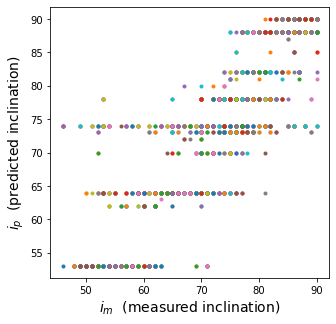

In [13]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5)) 


for i in range(len(measurments)):
    
    m = measurments[i]
    p = predictions[i]
    
    JF = ['J', 'F']
    
    if not m in JF and not p in JF:
        ax.plot(int(m), int(p), '.')
    

ax.set_xlabel(r'$i_m$'+'  (measured inclination)', fontsize=14)
ax.set_ylabel(r'$i_p$'+'  (predicted inclination)', fontsize=14)

In [14]:
## face-on galaxies

N = len(measurments)
TP = sum((measurments == 'F') & (predictions =='F'))
P = sum((measurments == 'F'))
TN = sum((measurments != 'F') & (predictions !='F'))
N = sum((measurments != 'F'))
FP = sum((measurments != 'F') & (predictions =='F'))


Accuracy = (TP+TN)/N/1.
Recall = TP/P/1. 
False_positive_rate = FP/N/1.

print("Accuracy: ", Accuracy)
print("True positive rate (Recall): ", Recall)
print("False positive rate: ", False_positive_rate)

Accuracy:  1.0040998881848677
True positive rate (Recall):  0.7613636363636364
False positive rate:  0.09578829668281774


In [15]:
## rejected galaxies

N = len(measurments)
TP = sum((measurments == 'J') & (predictions =='J'))
P = sum((measurments == 'J'))
TN = sum((measurments != 'J') & (predictions !='J'))
N = sum((measurments != 'J'))
FP = sum((measurments != 'J') & (predictions =='J'))


Accuracy = (TP+TN)/N/1.
Recall = TP/P/1. 
False_positive_rate = FP/N/1.

print("Accuracy: ", Accuracy)
print("True positive rate (Recall): ", Recall)
print("False positive rate: ", False_positive_rate)

Accuracy:  1.0
True positive rate (Recall):  0.0
False positive rate:  0.0


# Create Endpoint

In [16]:
from time import gmtime, strftime

timestamp = time.strftime("-%Y-%m-%d-%H-%M-%S", time.gmtime())
endpoint_config_name = job_name_prefix + "-epc-" + timestamp
endpoint_config_response = sage.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "InstanceType": "ml.m4.xlarge",
            "InitialInstanceCount": 1,
            "ModelName": model_name,
            "VariantName": "AllTraffic",
        }
    ],
)

print("Endpoint configuration name: {}".format(endpoint_config_name))
print("Endpoint configuration arn:  {}".format(endpoint_config_response["EndpointConfigArn"]))


Endpoint configuration name: DEMO-imageclassification-epc--2021-07-28-08-31-06
Endpoint configuration arn:  arn:aws:sagemaker:us-east-2:902996942887:endpoint-config/demo-imageclassification-epc--2021-07-28-08-31-06


In [17]:
%%time
import time

timestamp = time.strftime("-%Y-%m-%d-%H-%M-%S", time.gmtime())
endpoint_name = job_name_prefix + "-ep-" + timestamp
print("Endpoint name: {}".format(endpoint_name))

endpoint_params = {
    "EndpointName": endpoint_name,
    "EndpointConfigName": endpoint_config_name,
}
endpoint_response = sagemaker.create_endpoint(**endpoint_params)
print("EndpointArn = {}".format(endpoint_response["EndpointArn"]))

Endpoint name: DEMO-imageclassification-ep--2021-07-28-08-31-06
EndpointArn = arn:aws:sagemaker:us-east-2:902996942887:endpoint/demo-imageclassification-ep--2021-07-28-08-31-06
CPU times: user 14.8 ms, sys: 148 µs, total: 14.9 ms
Wall time: 176 ms


In [18]:
# get the status of the endpoint
response = sagemaker.describe_endpoint(EndpointName=endpoint_name)
status = response["EndpointStatus"]
print("EndpointStatus = {}".format(status))


# wait until the status has changed
sagemaker.get_waiter("endpoint_in_service").wait(EndpointName=endpoint_name)


# print the status of the endpoint
endpoint_response = sagemaker.describe_endpoint(EndpointName=endpoint_name)
status = endpoint_response["EndpointStatus"]
print("Endpoint creation ended with EndpointStatus = {}".format(status))

if status != "InService":
    raise Exception("Endpoint creation failed.")

EndpointStatus = Creating
Endpoint creation ended with EndpointStatus = InService


## Perform Inference

Finally, the customer can now validate the model for use. They can obtain the endpoint from the client library using the result from previous operations, and generate classifications from the trained model using that endpoint.

In [19]:
import boto3

runtime = boto3.Session().client(service_name="runtime.sagemaker")

In [20]:
import json
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def predictor(file_name):
    
    with open(file_name, "rb") as f:
        payload = f.read()
        payload = bytearray(payload)
    response = runtime.invoke_endpoint(
        EndpointName=endpoint_name, ContentType="application/x-image", Body=payload
    )
    result = response["Body"].read()
    # result will be in json format and convert it to ndarray
    result = json.loads(result)
    # the result will output the probabilities for all classes
    # find the class with maximum probability and print the class index
    index = np.argmax(result)    
    
    # displaying image
    img = Image.open(file_name)
    plt.imshow(img)
    
    print("Prediction: label - " + indexTOinc(index) + ", probability - " + str(result[index]))

### Evaluation

Evaluate the image through the network for inteference. 

Prediction: label - 88, probability - 0.1647806018590927


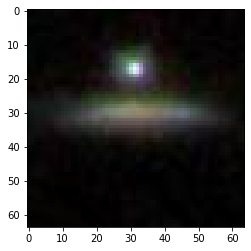

In [21]:
predictor("./test/87_pgc1280225_3.jpg")  # measured inclination is 87 deg

Prediction: label - 53, probability - 0.13258586823940277


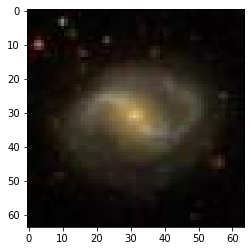

In [22]:
predictor("./test/50_pgc67934_2.jpg")  # measured inclination is 50 deg

Prediction: label - 64, probability - 0.07744613289833069


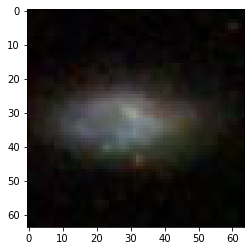

In [23]:
predictor("./test/65_pgc1653662_0.jpg")  # measured inclination is 65 deg

Prediction: label - F, probability - 0.9283777475357056


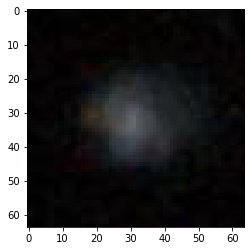

In [24]:
predictor("./test/F_pgc5807599_2.jpg")  # Face-on galaxy

Prediction: label - 74, probability - 0.9894269704818726


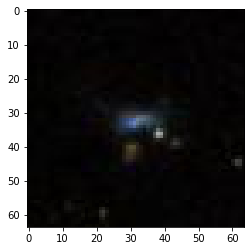

In [25]:
predictor("./test/J_pgc4339082_0.jpg")  # Rejected galaxy

## Clean up

When we’re done with the endpoint, we can just delete it and the backing instances will be released.

In [26]:
sage.delete_endpoint(EndpointName=endpoint_name)

{'ResponseMetadata': {'RequestId': '595a5437-7d0d-4758-b9dd-d77c143fcf1f',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '595a5437-7d0d-4758-b9dd-d77c143fcf1f',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Wed, 28 Jul 2021 08:38:39 GMT'},
  'RetryAttempts': 0}}